# 영화 추천 모델 구현하기
- 추천 시스템
  - CF
- 추천 알고리즘 탐색
  - Matrix Factorization, KNN, Latent Factorization
- 영화 추천 모델 실습
- 심화 학습


## 추천 시스템 (Recommender System)
> 사용자가 흥미, 관심을 가질 항목을 기존 정보를 바탕으로 추천하는 시스템  
> IF (Information Filtering)의 일종
- 중요성
  - 핵심 KPI에 기여
  - 사용자 행동 패턴 이해 및 서비스 개선에 적극기여
  - 수익화와 직접적인 연관
  - 도입 비용 대비 성능 측면 효과적
  - 일반화가 쉽다
- 동작 원리
  - 시스템 소비 이력 + 다른 소비자의 소비 이력
- 종류
  - 추천 시스템
    - 콘텐츠 기반 필터링
    - 하이브리드 필터링
    - 협업 필터링
      - 모델 기반
      - 하이브리드 기반
      - 기억 기반
        - 사용자 기반
        - 유저 기반
- 발전
  - 콘텐츠 기반 필터링
    - 과거 콘텐츠 기록 바탕으로 추천
  - 협업 필터링
    - 사용자간의 상호작용을 바탕으로 추천 항목 선정
  - 컨텍스트 기반 추천
    - 딥러닝 및 NLP 접근으로 보다 세부적인 맥락(Context) 기반 추천
    - 소비 및 상호작용 뿐만 아니라 예측되는 상황을 교려 (날씨, 뉴스,,,)

# 협업 필터링 (Collaborative Filtering : CF)

## 협업 필터링 (Collaborative Filtering : CF)
- 객체들(사용자들-제품들)간의 상호작용(좋음, 싫음) 정보가 있을때, 다른 객체의 상호작용 예측하는 방법
- 장단점
  |장점|단점|
  |----|----|
  |낮은 적용 비용|콜드 스타트 문제 (상호작용 정보가 적을때 (데이터 적을 때) 문제)|
  |관계만 다루기 때문에 콘텐츠 특성 무관|Sparse 데이터(데이터 비어 있는 것)로 인한 품질 저하|
  |모델 학습 불필요|편향 문제 (신규 없이 예전 아이템만 추천)|
- 사용자 기반 vs 아이템 기반
  | 비교 사항 | 사용자 기반 | 아이템 기반 |
  |--|--|--|
  |특징| 사용자 취향 | 아이템 소비 |
  |목적| 유사 사용자 기반 추천 | 유사 아이템 기반 추천 |
  |추천 항목| 나와 가까운 사용자 선호 아이템 | 나와 아이템 소비와 가까운 아이템 |
  |장점| 정밀한 추천 | 적은 데이터에도 대응 |
- 영화 추천
  | 사용자/영화 | 영화 1 | 영화 2 | 영화 3 | 영화 4 | 영화 5 |
  | - | - | - | - | - | - |
  | 사용자 1 | 4 | - | 5 | 3 | 4 |
  | 사용자 2 | 5 | 4 | - | 3 | 3 |
  | 사용자 3 | - | 3 | 4 | 5 | 4 |
  | 사용자 4 | 2 | 3 | 5 | - | 2 |
  | 사용자 5 | 4 | 4 | 4 | 4 | - |
- 영화 추천 : 사용자 기반
  - 각 사용자가 아직 안본 영화에 대해 평점을 어느 정도록 줄까?
  - 사용자들 간의 측면에서 유사도 계산
  - 다른 사용자와의 유사도를 통해 평점 계산
  - 높은 평점 순으로 아이템 추천  
- 영화 추천 : 아이템 기반
  - 다음 영화를 무엇으로 추천할까?
  - 아이템간의 유사도 계산
  - 현재 아이템을 1로 두고 높은 유사도 순으로 추천

In [2]:
%conda install tqdm

Retrieving notices: done
Channels:
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tqdm-4.67.1                |  py311h92b7b1e_0         164 KB
    ------------------------------------------------------------
                                           Total:         164 KB

The following packages will be UPDATED:

  tqdm                               4.66.5-py311h92b7b1e_0 --> 4.67.1-py311h92b7b1e_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import hashlib
from tqdm import tqdm
from datasets import load_dataset
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
data = {
    "영화 1": [4, 5, None, 2, 4],
    "영화 2": [None, 4, 3, 3, 4],
    "영화 3": [5, None, 4, 5, 4],
    "영화 4": [3, 3, 5, None, 4],
    "영화 5": [4, 3, 4, 2, None],
}
df = pd.DataFrame(data, index=["사용자 1", "사용자 2", "사용자 3", "사용자 4", "사용자 5"])

In [5]:
df

,영화 1,영화 2,영화 3,영화 4,영화 5
사용자 1,4.0,NaN,5.0,3.0,4.0
사용자 2,5.0,4.0,NaN,3.0,3.0
사용자 3,NaN,3.0,4.0,5.0,4.0
사용자 4,2.0,3.0,5.0,NaN,2.0
사용자 5,4.0,4.0,4.0,4.0,NaN


### 사용자 유사도 테이블
- Scikit Learn의 코사인 유사도(Cosine Similarity) 함수 활용

In [8]:
user_df = df.copy()
user_df = user_df.fillna(0)
user_similarity = cosine_similarity(user_df, user_df)
user_similarity_df = pd.DataFrame(user_similarity, index=user_df.index, columns=user_df.index)
user_similarity_df

,사용자 1,사용자 2,사용자 3,사용자 4,사용자 5
사용자 1,1.000000,0.657031,0.772727,0.778731,0.738549
사용자 2,0.657031,1.000000,0.624981,0.562480,0.781133
사용자 3,0.772727,0.624981,1.000000,0.702757,0.738549
사용자 4,0.778731,0.562480,0.702757,1.000000,0.771517
사용자 5,0.738549,0.781133,0.738549,0.771517,1.000000


### 아이템 유사도 테이블
- Scikit Learn의 코사인 유사도(Cosine Similarity) 함수 활용

In [14]:
item_df = np.transpose(df.copy())
item_df = item_df.fillna(0)
item_similarity = cosine_similarity(item_df, item_df)
item_similarity_df = pd.DataFrame(item_similarity, index=item_df.index, columns=item_df.index)
item_similarity_df

,영화 1,영화 2,영화 3,영화 4,영화 5
영화 1,1.000000,0.760500,0.650408,0.716766,0.668031
영화 2,0.760500,1.000000,0.671547,0.791694,0.632456
영화 3,0.650408,0.671547,1.000000,0.733225,0.757259
영화 4,0.716766,0.791694,0.733225,1.000000,0.795704
영화 5,0.668031,0.632456,0.757259,0.795704,1.000000


### 사용자 CF

In [12]:
full_df = df.copy()
for user_id in full_df.index:
    for movie_id in full_df.columns:
        if not np.isnan(full_df[movie_id][user_id]): continue

        similarities = user_similarity_df[user_id].copy()
        movie_ratings = full_df[movie_id].copy()

        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.dropna()
        similarities = similarities.drop(none_rating_idx)

        mean_rating = np.dot(similarities, movie_ratings) / similarities.sum()
        full_df.loc[user_id, movie_id] = round(mean_rating)

full_df


,영화 1,영화 2,영화 3,영화 4,영화 5
사용자 1,4.0,3.0,5.0,3.0,4.0
사용자 2,5.0,4.0,4.0,3.0,3.0
사용자 3,4.0,3.0,4.0,5.0,4.0
사용자 4,2.0,3.0,5.0,4.0,2.0
사용자 5,4.0,4.0,4.0,4.0,3.0


In [13]:
watched_movies = ["영화 4", "영화 3"]
item_similarity_df[watched_movies[0]][~item_similarity_df.index.isin(watched_movies)].sort_values(ascending=False)[:3]

영화 5    0.795704
영화 2    0.791694
영화 1    0.716766
Name: 영화 4, dtype: float64

### 다른 데이터 활용

In [17]:
data = load_dataset("nbtpj/movielens-1m-ratings")["train"].shuffle(seed=10)
n_chunks = 100
chunk_size = len(data) // n_chunks
if len(data) % n_chunks != 0 : chunk_size += 1

movielens_df = pd.DataFrame()

for start in tqdm(range(0, len(data), chunk_size)):
    end = start + chunk_size
    chunk_df = pd.DataFrame(data[start:end])
    movielens_df = pd.concat([movielens_df, chunk_df], ignore_index=True)

movielens_df = movielens_df[["user_id", "movie_id", "user_rating"]]

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


In [18]:
movielens_df

,user_id,movie_id,user_rating
0,b'3032',b'782',5.0
1,b'5963',b'2716',4.0
2,b'2088',b'2019',5.0
3,b'2340',b'3253',5.0
4,b'3942',b'1200',4.0
...,...,...,...
1000204,b'4777',b'3461',4.0
1000205,b'2986',b'1345',4.0
1000206,b'854',b'3253',3.0
1000207,b'3462',b'2734',4.0


In [19]:
user_item_matrix = movielens_df.pivot_table(index="user_id", columns="movie_id", values="user_rating")
user_item_matrix
# 빈 데이터가 많기에 매우 Sparse한 데이터라고 할 수 있다.

movie_id,b'1',b'10',b'100',b'1000',b'1002',b'1003',b'1004',b'1005',b'1006',b'1007',b'1008',b'1009',b'101',b'1010',b'1011',b'1012',b'1013',b'1014',b'1015',b'1016',b'1017',b'1018',b'1019',b'102',b'1020',b'1021',b'1022',b'1023',b'1024',b'1025',b'1026',b'1027',b'1028',b'1029',b'103',b'1030',b'1031',b'1032',b'1033',b'1034',...,b'960',b'961',b'962',b'963',b'964',b'965',b'966',b'967',b'968',b'969',b'97',b'970',b'971',b'972',b'973',b'974',b'975',b'976',b'977',b'978',b'98',b'980',b'981',b'982',b'984',b'985',b'986',b'987',b'988',b'989',b'99',b'990',b'991',b'992',b'993',b'994',b'996',b'997',b'998',b'999'
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'1',5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'10',5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,3.0,NaN,NaN,3.0,5.0,NaN,NaN,4.0,NaN,3.0,NaN,5.0,5.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,3.0,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'100',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'1000',5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'1001',4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'995',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b'996',4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
b'997',4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
user_similarity = cosine_similarity(csr_matrix(user_item_matrix.fillna(0))) ## csr_matrix를 통해 반복 연산 효율화 
user_similarity = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

def predict_rating(user_id: str, movie_id: str):
    movie_ratings = user_item_matrix[movie_id]
    user_similarities = user_similarity[user_id]
    valid_indices = movie_ratings.notna()
    movie_ratings = movie_ratings[valid_indices]
    user_similarities = user_similarities[valid_indices]

    if user_similarities.sum() > 0:
        return np.dot(user_similarities, movie_ratings) / user_similarities.sum()
    return movielens_df[movielens_df["movie_id"] == movie_id]["user_rating"].mean()

user_similarity

user_id,b'1',b'10',b'100',b'1000',b'1001',b'1002',b'1003',b'1004',b'1005',b'1006',b'1007',b'1008',b'1009',b'101',b'1010',b'1011',b'1012',b'1013',b'1014',b'1015',b'1016',b'1017',b'1018',b'1019',b'102',b'1020',b'1021',b'1022',b'1023',b'1024',b'1025',b'1026',b'1027',b'1028',b'1029',b'103',b'1030',b'1031',b'1032',b'1033',...,b'963',b'964',b'965',b'966',b'967',b'968',b'969',b'97',b'970',b'971',b'972',b'973',b'974',b'975',b'976',b'977',b'978',b'979',b'98',b'980',b'981',b'982',b'983',b'984',b'985',b'986',b'987',b'988',b'989',b'99',b'990',b'991',b'992',b'993',b'994',b'995',b'996',b'997',b'998',b'999'
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b'1',1.000000,0.255288,0.123967,0.207800,0.139061,0.110320,0.121384,0.179143,0.103137,0.052816,0.060032,0.102675,0.049839,0.029990,0.158998,0.078094,0.080898,0.047769,0.195850,0.175148,0.132802,0.142788,0.178819,0.112310,0.119980,0.034848,0.090209,0.111133,0.099425,0.022982,0.028506,0.004729,0.143985,0.045708,0.187819,0.032611,0.045869,0.057829,0.181461,0.031882,...,0.216808,0.113513,0.228051,0.057437,0.067666,0.078741,0.161922,0.066990,0.117169,0.077286,0.033210,0.233381,0.097345,0.113281,0.070842,0.139390,0.038319,0.125029,0.127897,0.248908,0.098165,0.046992,0.108046,0.179191,0.179705,0.043704,0.156864,0.200921,0.101250,0.208325,0.079367,0.038048,0.032136,0.066641,0.070052,0.035731,0.170184,0.159267,0.119356,0.122059
b'10',0.255288,1.000000,0.258047,0.278753,0.154858,0.112222,0.141111,0.428224,0.188569,0.101856,0.160734,0.219440,0.115671,0.204174,0.348802,0.198759,0.152132,0.156608,0.157343,0.390245,0.200637,0.283837,0.239921,0.331964,0.162295,0.107090,0.189606,0.108169,0.126938,0.136483,0.075916,0.037347,0.146672,0.083205,0.291860,0.152799,0.235402,0.271768,0.226634,0.201777,...,0.383153,0.211291,0.219539,0.058389,0.151520,0.151131,0.113503,0.201743,0.244708,0.319444,0.144173,0.306821,0.226470,0.295447,0.079463,0.290479,0.071700,0.164075,0.109399,0.269550,0.269880,0.153394,0.190825,0.432573,0.272358,0.020549,0.302080,0.192870,0.129796,0.202529,0.153462,0.186086,0.083224,0.123288,0.117829,0.145650,0.300175,0.160346,0.132506,0.246251
b'100',0.123967,0.258047,1.000000,0.297539,0.075597,0.110450,0.358686,0.236065,0.171609,0.099147,0.060103,0.043367,0.061238,0.347549,0.262156,0.139793,0.085678,0.024211,0.292006,0.194110,0.171057,0.141068,0.337496,0.192321,0.009131,0.176147,0.195809,0.070161,0.087403,0.066152,0.070635,0.031957,0.211235,0.098388,0.149484,0.223646,0.400578,0.387974,0.092417,0.141394,...,0.289363,0.042976,0.180097,0.119606,0.032365,0.064299,0.132182,0.118383,0.233631,0.344658,0.045907,0.221359,0.235123,0.270069,0.092616,0.230064,0.031021,0.203071,0.211965,0.273071,0.158548,0.110668,0.148955,0.246383,0.313518,0.068915,0.216167,0.187875,0.047711,0.154743,0.098235,0.097953,0.065152,0.176048,0.271311,0.033754,0.344290,0.204302,0.113522,0.306104
b'1000',0.207800,0.278753,0.297539,1.000000,0.094710,0.047677,0.201722,0.353782,0.323584,0.130702,0.042828,0.077724,0.123638,0.282423,0.248381,0.124237,0.117258,0.050799,0.179805,0.217813,0.090189,0.196132,0.364062,0.200980,0.102801,0.141890,0.170695,0.056812,0.039899,0.018445,0.115536,0.029414,0.152463,0.069294,0.220646,0.167508,0.341998,0.322370,0.143107,0.128474,...,0.314772,0.113307,0.161293,0.065396,0.057284,0.050558,0.073921,0.125145,0.207352,0.209789,0.058155,0.169072,0.305570,0.222372,0.076149,0.234935,0.045171,0.218874,0.124645,0.367763,0.192260,0.082288,0.146378,0.262129,0.359567,0.000000,0.124945,0.175711,0.043119,0.183777,0.170100,0.076779,0.000000,0.197410,0.380741,0.044404,0.330748,0.172803,0.098456,0.245292
b'1001',0.139061,0.154858,0.075597,0.094710,1.000000,0.164551,0.053788,0.149019,0.137336,0.134462,0.019540,0.083497,0.200043,0.067775,0.251583,0.072368,0.037393,0.073467,0.059556,0.298098,0.293565,0.100733,0.065301,0.165053,0.174044,0.154019,0.094506,0.266318,0.048713,0.066258,0.119893,0.126163,0.076968,0.045484,0.153981,0.098262,0.088469,0.081548,0.226173,0.102571,...,0.293779,0.219163

100%|██████████| 20005/20005 [00:15<00:00, 1303.84it/s]


Accuracy: 0.3898525368657835


Text(0, 0.5, 'Cumulative Accuracy')

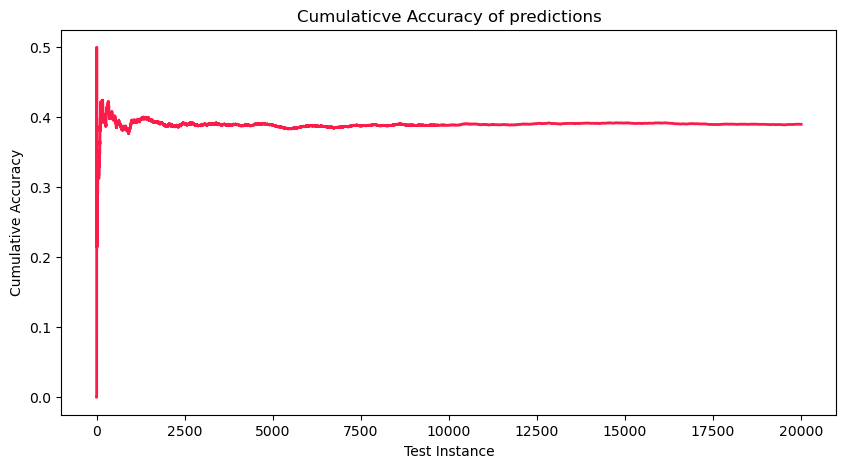

In [26]:
train_data, test_data = train_test_split(movielens_df, test_size=0.02, random_state=10)

predictions: list[float] = []
true_ratings: list[float] = []

for idx, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    prediction = predict_rating(row["user_id"], row["movie_id"])
    predictions.append(prediction)
    true_ratings.append(row["user_rating"])

rounded_predictions = [round(pred) for pred in predictions]
accuracy = accuracy_score(true_ratings, rounded_predictions)
print(f"Accuracy: {accuracy}")

cumulative_accuracy = np.cumsum(np.array(rounded_predictions) == np.array(true_ratings)) / (np.arange(len(test_data)) + 1)

plt.figure(figsize=(10,5))
plt.plot([i for i in range(len(test_data))], cumulative_accuracy, linewidth=2, color="#fc1c49")
plt.title("Cumulaticve Accuracy of predictions")
plt.xlabel("Test Instance")
plt.ylabel("Cumulative Accuracy")